# Cora Dataset Example

In this example, I am given the ground truth labels of a small subset of nodes and want to infer the labels for all of the remaining nodes.

The dataset used is the *Cora* dataset, which is a citation network where nodes represent documents. This dataset consists of 2708 scientific publications classified into one of seven classes. Each node is described by a 1433-dim bag of words feature vector. Two nodes (documents) are connected if there exists a citation link between them.

**The task is to infer the category of each document.**

In [1]:
# install necessary packages

%pip install torch_geometric # install pytorch geometric
%pip install torchvision #install torchvision
%pip install matplotlib #install matplotlib
%pip install graphviz # install graphviz

%matplotlib inline

from torch_geometric.data import Data, DataLoader
from torch_geometric.explain import GNNExplainer,Explainer,GraphMaskExplainer,PGExplainer
import torch_geometric.transforms as T
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATv2Conv
from torch.nn import Linear,Softmax
import os
from tqdm import tqdm, trange
import pickle

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root = 'data/Planetoid', name='Cora', transform=NormalizeFeatures())
# the normalize features transformation row-normalizes the attributes to sum up functional name

print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

#get the graph object in the Cora dataset
data = dataset[0]

print()
print("Information about dataset:")
print(data)
print("Here we can see that the data is formatted as a vector of 2708 rows for 2708 publications with 1433 columns with the bag of words vector")
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Processing...
Done!


Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Information about dataset:
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Here we can see that the data is formatted as a vector of 2708 rows for 2708 publications with 1433 columns with the bag of words vector
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


As we can see, this dataset holds 2708 nodes with 10556 edges. We are given the ground truth categories of 140 nodes and therefore, have a training node label rate of 5%.

The `val_mask` and `test_mask` denote which nodes should be used for validation and testing.

We want to try to infer the category of the document solely based on its content (bag-of-words feature representation) without the relational information (edges).

## Training the GNN

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

The GCN Layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [3]:
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
  def __init__(self, hidden_channels):
    super().__init__()
    torch.manual_seed(1234567)
    self.conv1 = GCNConv(dataset.num_features, hidden_channels)
    self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

  def forward(self, x, edge_index):
    x = self.conv1(x, edge_index)
    x = x.relu()
    x = F.dropout(x, p=0.5, training=self.training)
    x = self.conv2(x, edge_index)
    return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [4]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
  model.train()
  optimizer.zero_grad()
  out = model(data.x, data.edge_index)
  # this performs a single forward pass
  loss = criterion(out[data.train_mask], data.y[data.train_mask])
  # ^ Compute the loss solely based on the training nodes.
  loss.backward() # derive gradients
  optimizer.step() # update parameters based on gradients
  return loss

def test():
  model.eval()
  out = model(data.x, data.edge_index)
  pred = out.argmax(dim=1)
  test_correct = pred[data.test_mask] == data.y[data.test_mask]
  test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
  return test_acc

for epoch in range(1, 101):
    loss = train()

## GNN Explainer

Now, I am going to try using GNN Explainer as an interpretability method on this node classification task.

In [5]:
from torch_geometric.explain import Explainer, GNNExplainer

"""
GNNEXPLAINER will generate an explanation by identifying a subgraph of the computation
graph and a subset of node features that are most influential for the model Φ’s prediction

Given a node v, our goal is to identify a subgraph GS ⊆ Gc and the associated features XS =
{xj |vj ∈ GS} that are important for the GNN’s prediction y

"""

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', #  mask each node feature separately across all nodes
    edge_mask_type='object', # mask each edge
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

explanation = explainer(data.x, data.edge_index, index=10)

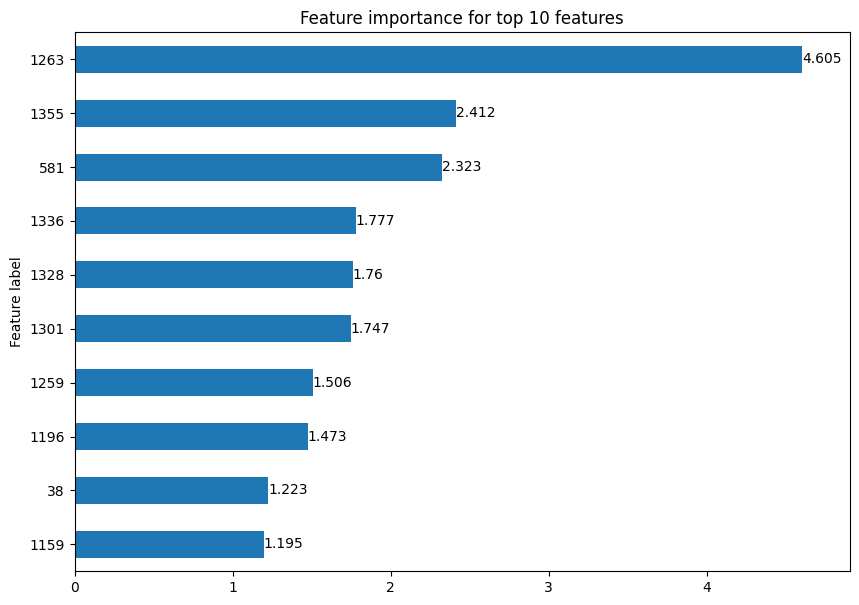

In [6]:
explanation.visualize_feature_importance(top_k=10)

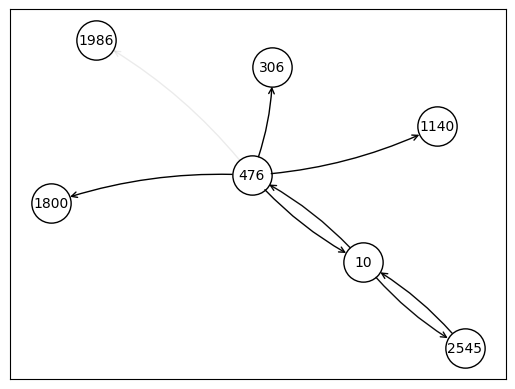

In [7]:
explanation.visualize_graph(backend='networkx')

In [8]:
"""
Fidelity evaluates the contribution of the produced explanatory subgraph to the initial prediction,
either by giving only the subgraph to the model (fidelity-) or by removing it from the entire graph (fidelity+).

Fidelity- close to 0 is good because it shows that the the explainer is better. The explanation given is quite sufficient.

The fidelity scores capture how good an explainable model reproduces the natural phenomenon or the GNN model logic.
Once we have produced an explanation we can obtain both fidelities as:
"""

from torch_geometric.explain.metric import fidelity

fid_pm = fidelity(explainer, explanation)
print(fid_pm)

(1.0, 0.0)


Now, I am going to try and play around with different parameters for gnn explainer. 


In [26]:
gnn_explainer2 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='common_attributes', #  change to common attributes
    edge_mask_type='object', 
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

"""
This configuration yields an error. So, I believe the node mask of common attributes cannot be used with the edge mask of object. 

Error Message: ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.
"""

gnn_explanation2 = gnn_explainer2(data.x, data.edge_index, index=10)
gnn_explanation2.visualize_feature_importance(top_k=10)
gnn_explanation2.visualize_graph(backend='networkx')

ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.

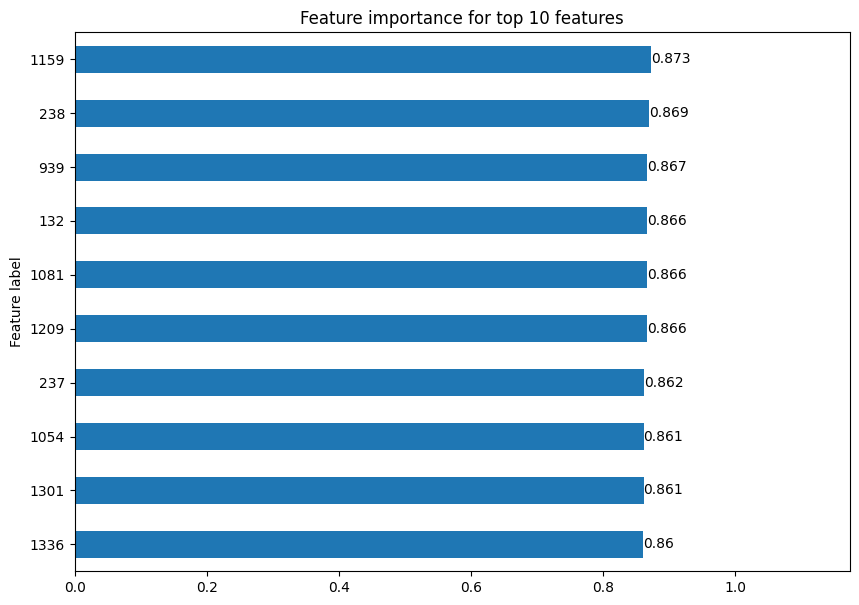

ValueError: The attribute 'edge_mask' is not available in 'Explanation' (got ['node_mask'])

In [30]:
# Based on above error, I am editing this explanation to have edge mask of None

gnn_explainer3 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='common_attributes', #  change to common attributes
    edge_mask_type=None, #change to None
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation3 = gnn_explainer3(data.x, data.edge_index, index=10)
gnn_explanation3.visualize_feature_importance(top_k=10)
gnn_explanation3.visualize_graph()

"""
This configuration does work, however, we can see that the features found are different and have similar importance. Is this because it is trying to find the same set of 10
important attributes for all of the nodes in the graph? 

Also, since we have no edge mask, a visualization cannot be developed, which makes sense I think. 
"""

In [34]:
# Now, I am going to try keeping everything the same except I am going to add a threshold configuration

gnn_explainer4 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type='object', 
    threshold_config=dict(
        threshold_type="topk",
        value=2 #Threshold Value is an integer -> how do I know what value to put here? 
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

"""
This configuration returns the same error seen above. Idk. 

Error Message: ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.
"""

gnn_explanation4 = gnn_explainer4(data.x, data.edge_index, index=10)
gnn_explanation4.visualize_feature_importance(top_k=10)
gnn_explanation4.visualize_graph(backend='networkx')

ValueError: Could not compute gradients for edges. Please make sure that edges are used via message passing inside the model or disable it via `edge_mask_type=None`.

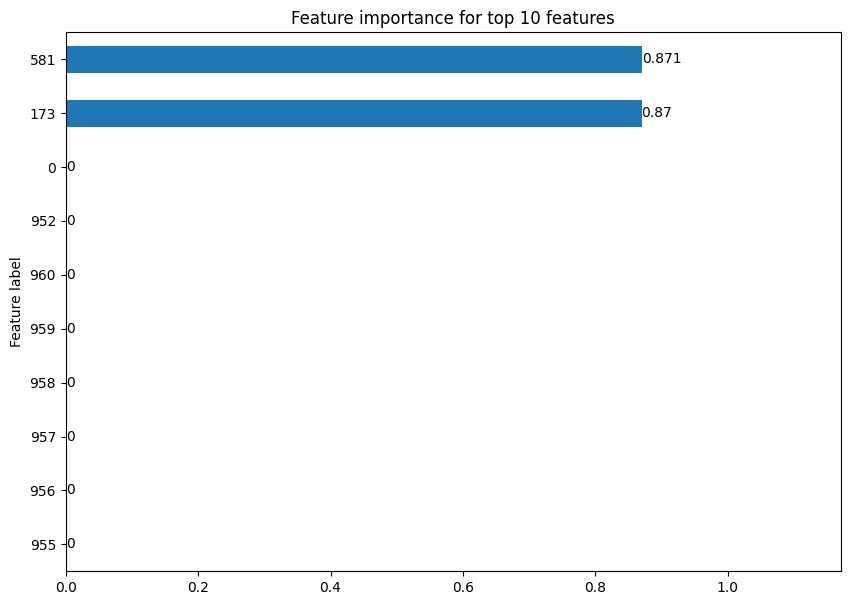

ValueError: The attribute 'edge_mask' is not available in 'Explanation' (got ['node_mask'])

In [43]:
# To fix the above error, I will be changing the edge mask to None to see what happens. 

gnn_explainer5 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type=None, 
    threshold_config=dict(
        threshold_type="topk",
        value=2 #Threshold Value is an integer -> how do I know what value to put here? 
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation5 = gnn_explainer5(data.x, data.edge_index, index=10)
gnn_explanation5.visualize_feature_importance(top_k=10)
gnn_explanation5.visualize_graph(backend='networkx')

"""
does this mean that the threshold value is too low?? Also, when I run this, it gives different results (almost) every time?? 
"""

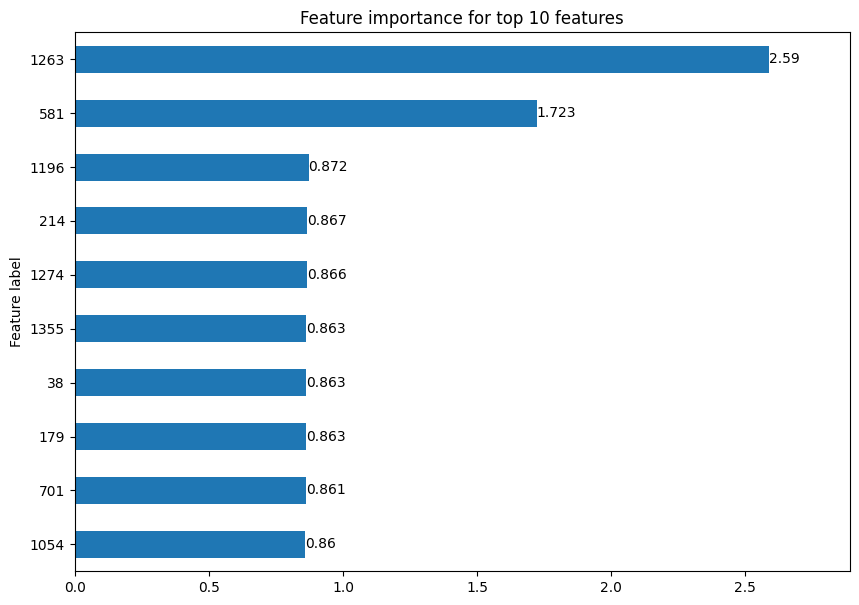

ValueError: The attribute 'edge_mask' is not available in 'Explanation' (got ['node_mask'])

In [44]:
# To fix the above error, I will be changing the edge mask to None to see what happens. 

gnn_explainer6 = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes', 
    edge_mask_type=None, 
    threshold_config=dict(
        threshold_type="topk",
        value=20 #Threshold Value is an integer -> how do I know what value to put here? 
    ),
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  
    ),
)

gnn_explanation6 = gnn_explainer6(data.x, data.edge_index, index=10)
gnn_explanation6.visualize_feature_importance(top_k=10)
gnn_explanation6.visualize_graph(backend='networkx')

"""
As the threshold increases, it seems like the features align with what we found originally. 
"""

## PG Explainer

Next, we will try to use PGExplainer.

In [9]:
from torch_geometric.explain import PGExplainer, ModelConfig

explainer2 = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

# Train against a variety of node-level or graph-level predictions:
for epoch in range(30): # Indices to train against.
        loss = explainer2.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, index=10)
# Get the final explanations:
explanation = explainer2(data.x, data.edge_index, target=data.y, index=10)

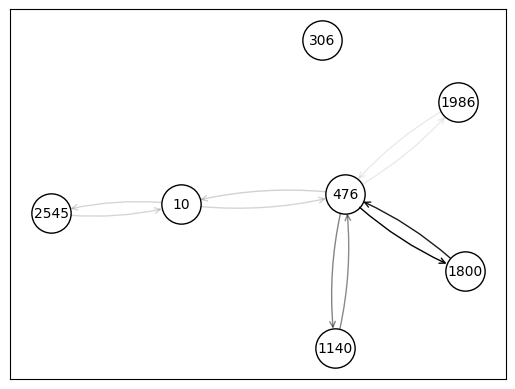

In [10]:
explanation.visualize_graph(backend='networkx')

In [11]:
fid_pm = fidelity(explainer, explanation)
print(fid_pm)

(0.0, 1.0)


## GraphMask

Now, we will try to use GraphMask Explainer.

In [12]:
from torch_geometric.explain import GraphMaskExplainer

explainer3 = Explainer(
    model=model,
    algorithm=GraphMaskExplainer(2, epochs=5),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
)

node_index = 10
explanation = explainer3(data.x, data.edge_index, index=node_index)
print(f'Generated explanations in {explanation.available_explanations}')

Train explainer for node(s) tensor([10]) with layer 1: 100%|██████████| 5/5 [00:00<00:00, 19.43it/s]
Train explainer for node(s) tensor([10]) with layer 0: 100%|██████████| 5/5 [00:00<00:00, 24.53it/s]
Explain: 100%|██████████| 2/2 [00:00<00:00, 353.98it/s]

Generated explanations in ['edge_mask', 'node_mask']


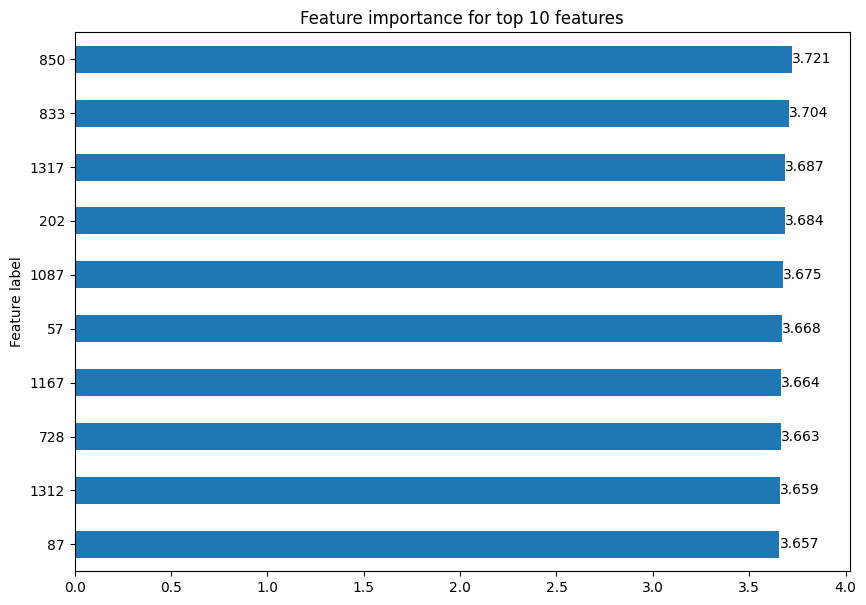

In [13]:
explanation.visualize_feature_importance(top_k=10)

In [16]:
explanation.visualize_graph(backend='graphviz')

In [15]:
fid_graphmask = fidelity(explainer3, explanation)
print(fid_graphmask)

(1.0, 1.0)
